<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/Sensor40.unet-2610-noaugonvalidation-7e-5-roiadjusted-relu-batch12-2blocks-batcheverywhere-relualsoonbidirectional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:

import os
from IPython.core.completer import time
from natsort import natsorted
from tensorflow.keras.preprocessing.image import (
    array_to_img,
    img_to_array,
    load_img,
)
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np

In [3]:
class DataLoader:
    def __init__(
        self,
        *,
        data_path,
        timesteps: int = 3,
        batch_size: int = 12,
        squeeze=False,
        augmentation=True,
        sort_method="natsort" # oppure "number"
    ):

        self.do_augmentation = augmentation
        self.timesteps = timesteps
        self.batch_size = 12
        self.squeeze = squeeze
        self.data_path = data_path
        train_img_file_names = [
            os.path.join(data_path, fn)
            for fn in os.listdir(
                data_path
            )  # os.listdir(os.path.join(data_folder, "train_images", "images"))
        ]
        def sort_by_number(file_names:str):
            return sorted(names, key=lambda x: int(x.split('/')[-1].split('.')[0]))

        train_img_file_names = natsorted(train_img_file_names) if sort_method == "natsort" else sort_by_number(train_img_file_names)
        # train_img_file_names.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        train_mask_file_names = [
            fn.replace("images", "masks") for fn in train_img_file_names
        ]
        self.imgs = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in train_img_file_names
                ]
            )
            / 255
        )
        self.masks = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in train_mask_file_names
                ]
            )
            / 255
            > 0.5
        ).astype(float)
        self.augmentation = tf.keras.Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical"),
                layers.RandomRotation(0.2),
            ]
        )

    def __iter__(self):
        return self

    def __next__(self):
        xs = []
        ys = []
        for _ in range(self.batch_size):
            index = np.random.randint(0, len(self.imgs) - self.timesteps)
            xs.append(self.imgs[index : index + self.timesteps])
            ys.append(self.masks[index + self.timesteps])
        x, y = np.array(xs), np.array(ys)
        x = x.squeeze(-1).transpose(0, 2, 3, 1)
        xy = tf.concat((x, y), axis=-1)
        if self.do_augmentation:
            xy = self.augmentation(xy)

        x = xy[:, :, :, :3]
        y = xy[:, :, :, 3:]
        if not self.squeeze:
            x = tf.transpose(x, perm=(0, 3, 1, 2))[..., None]
            y = tf.expand_dims(y, 1)
        # if not tf.reduce_all(y[0] == 0):
        #    ipdb.set_trace()
        return x, y

In [4]:
val_loader = DataLoader(
    data_path=os.path.join(
        "/gdrive/MyDrive/adjustedROI/final_output",
        "val_images", "images"
    ),
    batch_size=12,
    squeeze=False,
    augmentation=False,
)

train_loader = DataLoader(
    data_path=os.path.join(
        "/gdrive/MyDrive/adjustedROI/final_output", "train_images", "images"
    ),
    batch_size=12,
    squeeze=False,
    augmentation=True,
)


In [5]:
x, y = train_loader.__next__()

In [6]:
from matplotlib import pyplot as plt

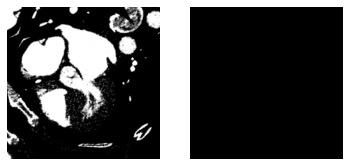

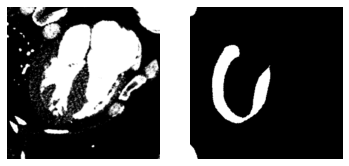

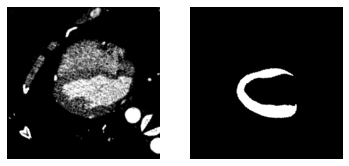

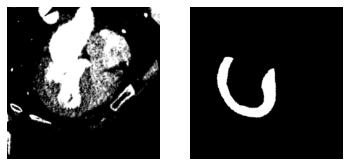

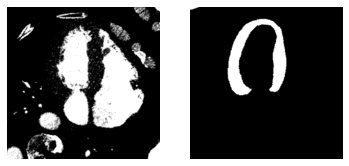

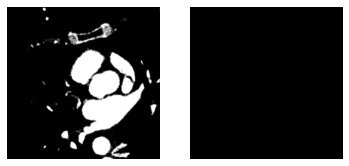

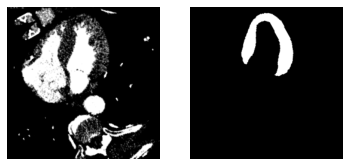

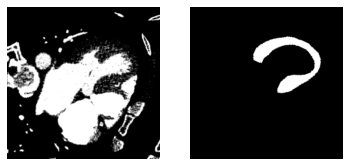

In [7]:
x, y = train_loader.__next__()

for i in range(0,8):
    image = x[i,0,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= y[i,0,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [8]:
x.shape

TensorShape([12, 3, 256, 256, 1])

In [9]:
y.shape

TensorShape([12, 1, 256, 256, 1])

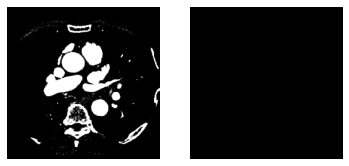

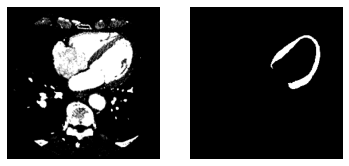

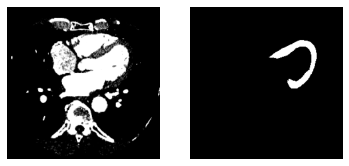

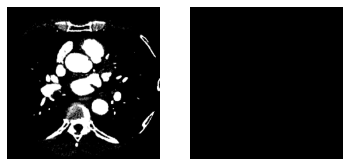

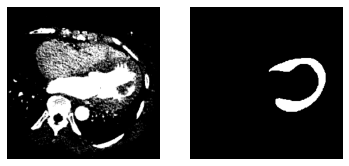

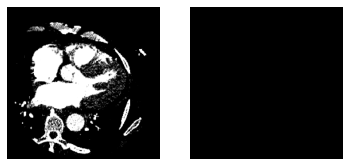

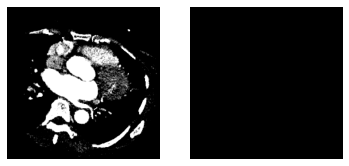

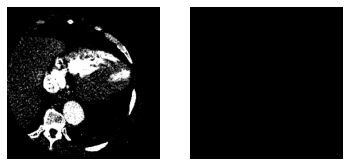

In [10]:
x, y = val_loader.__next__()

for i in range(0,8):
    image = x[i,0,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= y[i,0,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [11]:
batch_size=12

In [12]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/gdrive/MyDrive/adjustedROI/final_output/train_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/adjustedROI/final_output/val_images/images'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, TimeDistributed,Dropout,Input, Dense,\
    BatchNormalization, GRU, Layer, Flatten,MaxPooling2D, concatenate,Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import models
from tensorflow.python.keras.layers import ConvLSTM2D

In [14]:
input_shape=(3,256,256,1)

In [15]:
input_l = layers.Input(shape=(input_shape))
x =  (layers.TimeDistributed(layers.Conv2D( 16, kernel_size=(3, 3),padding='same',strides=(1,1), kernel_initializer='he_normal', activation='relu' ))) (input_l)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
conv2 = layers.TimeDistributed( layers.Conv2D( 16, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal',activation='relu' ) ) (x)
conv2=layers.TimeDistributed(layers.BatchNormalization())(conv2)

x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv2)

x = layers.TimeDistributed( layers.Conv2D( 32, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal',activation='relu' ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
conv5 = layers.TimeDistributed( layers.Conv2D( 32, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal',activation='relu' ) ) (x)
conv5=layers.TimeDistributed(layers.BatchNormalization())(conv5)


x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv5)

x = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal',activation='relu' ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)

conv8 = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal',activation='relu' ) ) (x)
conv8=layers.TimeDistributed(layers.BatchNormalization())(conv8)

x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv8)

x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal',activation='relu' ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)

conv9 = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal',activation='relu' ) ) (x)
conv9=layers.TimeDistributed(layers.BatchNormalization())(conv9)

x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv9)

x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal',activation='relu' ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)

conv10 = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal',activation='relu' ) ) (x)
conv10=layers.TimeDistributed(layers.BatchNormalization())(conv10)

x=layers.Bidirectional(layers.ConvLSTM2D(256,kernel_size=(3,3),padding='same',strides=(1,1),return_sequences=True,recurrent_dropout=0.2,activation='relu'))(conv10)
up1 = layers.TimeDistributed( layers.Conv2DTranspose(128,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
#expanding path
concat1 = layers.concatenate([up1, conv9])
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ,kernel_initializer='he_normal',activation='relu') ) (concat1)
x=layers.TimeDistributed(layers.Dropout(0.1))(x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ,kernel_initializer='he_normal',activation='relu') ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
up2 = layers.TimeDistributed( layers.Conv2DTranspose( 64,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat2 = layers.concatenate([up2, conv8])
x = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1) ,kernel_initializer='he_normal',activation='relu') ) (concat2)
x=layers.TimeDistributed(layers.Dropout(0.1))(x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
up3 = layers.TimeDistributed( layers.Conv2DTranspose( 32,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat3 = layers.concatenate([up3, conv5])

x = layers.TimeDistributed( layers.Conv2D( 32, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal',activation='relu' ) ) (concat3)
x=layers.TimeDistributed(layers.Dropout(0.1))(x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed( layers.Conv2D( 32, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal',activation='relu' ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
up4= layers.TimeDistributed( layers.Conv2DTranspose( 16,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat4 = layers.concatenate([up4, conv2])
x = layers.TimeDistributed( layers.Conv2D( 16, kernel_size=(3, 3),padding='same',strides=(1,1), kernel_initializer='he_normal',activation='relu') ) (concat4)
x=layers.TimeDistributed(layers.Dropout(0.1))(x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed( layers.Conv2D( 16, kernel_size=(3, 3),padding='same',strides=(1,1),kernel_initializer='he_normal' ,activation='relu') ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
x=layers.Bidirectional(layers.ConvLSTM2D(16,kernel_size=(3,3),padding='same',strides=(1,1),return_sequences=False,recurrent_dropout=0.2,activation='relu'))(x)
x=tf.expand_dims(x,axis=1)
x=layers.TimeDistributed(layers.BatchNormalization())(x)

out = layers.Conv2D( 1, kernel_size=(1, 1),padding='same',strides=(1,1), activation='sigmoid' )  (x)


model = models.Model(inputs=input_l, outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                , 1)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 3, 256, 256,  160        ['input_1[0][0]']                
 ted)                            16)                                                              
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 3, 256, 256,  64         ['time_distributed[0][0]']       
 buted)                          16)                                                          

In [16]:
from keras import backend as K


def dice_coefficient(y_true, y_pred, smooth=0.0001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return ((2. * intersection + smooth) / (K.sum(y_true_f) +
            K.sum(y_pred_f) + smooth))


def dice_coefficient_loss(y_true, y_pred):
    return 1.0-dice_coefficient(y_true, y_pred)


def iou_loss(y_true, y_pred):
    return 1-iou(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.square(y_true)) + K.sum(K.square(y_pred))
    jac = (intersection) / (sum_ - intersection)
    return jac

In [17]:
LR = 7e-5
optim = tf.keras.optimizers.Adam(LR)

In [18]:
metrics=[dice_coefficient, 'binary_accuracy']


In [19]:
model.compile(optimizer=optim, loss=dice_coefficient_loss, metrics=metrics)


In [20]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/gdrive/MyDrive/chk/',
    save_weights_only=True,
    monitor='val_dice_coefficient',
    mode='max',
    save_best_only=True)


In [21]:
history=model.fit(train_loader,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_loader,
          callbacks=model_checkpoint_callback,
          validation_steps=val_steps_per_epoch)

Epoch 1/40
248/248 [==============================] - 424s 2s/step - loss: 0.8729 - dice_coefficient: 0.1271 - binary_accuracy: 0.7097 - val_loss: 0.9584 - val_dice_coefficient: 0.0416 - val_binary_accuracy: 0.3970
Epoch 2/40
248/248 [==============================] - 391s 2s/step - loss: 0.7874 - dice_coefficient: 0.2126 - binary_accuracy: 0.8783 - val_loss: 0.8802 - val_dice_coefficient: 0.1198 - val_binary_accuracy: 0.8465
Epoch 3/40
248/248 [==============================] - 391s 2s/step - loss: 0.7218 - dice_coefficient: 0.2782 - binary_accuracy: 0.9253 - val_loss: 0.7429 - val_dice_coefficient: 0.2571 - val_binary_accuracy: 0.9453
Epoch 4/40
248/248 [==============================] - 390s 2s/step - loss: 0.6489 - dice_coefficient: 0.3511 - binary_accuracy: 0.9479 - val_loss: 0.8222 - val_dice_coefficient: 0.1778 - val_binary_accuracy: 0.9512
Epoch 5/40
248/248 [==============================] - 390s 2s/step - loss: 0.5791 - dice_coefficient: 0.4209 - binary_accuracy: 0.9609 - val

In [22]:
model.save('/gdrive/MyDrive/Sensor40.unet-2610-noaugonvalidation-7e-5-roiadjusted-relu-batch12-2blocks-batcheverywhere-relualsoonbidirectional.h5')

In [23]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/Sensor40.unet-2610-noaugonvalidation-7e-5-roiadjusted-relu-batch12-2blocks-batcheverywhere-relualsoonbidirectional.h5", compile=False)

In [31]:
class DataLoader:
    def __init__(
        self,
        *,
        data_path,
        timesteps: int = 3,
        batch_size: int = 477,
        squeeze=False,
        augmentation=True,
        sort_method="natsort" # oppure "number"
    ):

        self.do_augmentation = augmentation
        self.timesteps = timesteps
        self.batch_size = 477
        self.squeeze = squeeze
        self.data_path = data_path
        train_img_file_names = [
            os.path.join(data_path, fn)
            for fn in os.listdir(
                data_path
            )  # os.listdir(os.path.join(data_folder, "train_images", "images"))
        ]
        def sort_by_number(file_names:str):
            return sorted(names, key=lambda x: int(x.split('/')[-1].split('.')[0]))

        train_img_file_names = natsorted(train_img_file_names) if sort_method == "natsort" else sort_by_number(train_img_file_names)
        # train_img_file_names.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        train_mask_file_names = [
            fn.replace("images", "masks") for fn in train_img_file_names
        ]
        self.imgs = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in train_img_file_names
                ]
            )
            / 255
        )
        self.masks = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in train_mask_file_names
                ]
            )
            / 255
            > 0.5
        ).astype(float)
        self.augmentation = tf.keras.Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical"),
                layers.RandomRotation(0.3),
            ]
        )

    def __iter__(self):
        return self

    def __next__(self):
        xs = []
        ys = []
        for _ in range(self.batch_size):
            index = np.random.randint(0, len(self.imgs) - self.timesteps)
            xs.append(self.imgs[index : index + self.timesteps])
            ys.append(self.masks[index + self.timesteps])
        x, y = np.array(xs), np.array(ys)
        x = x.squeeze(-1).transpose(0, 2, 3, 1)
        xy = tf.concat((x, y), axis=-1)
        if self.do_augmentation:
            xy = self.augmentation(xy)

        x = xy[:, :, :, :3]
        y = xy[:, :, :, 3:]
        if not self.squeeze:
            x = tf.transpose(x, perm=(0, 3, 1, 2))[..., None]
            y = tf.expand_dims(y, 1)
        # if not tf.reduce_all(y[0] == 0):
        #    ipdb.set_trace()
        return x, y

In [32]:
val_loader = DataLoader(
    data_path=os.path.join(
        "/gdrive/MyDrive/adjustedROI/final_output",
        "val_images", "images"
    ),
    batch_size=477,
    squeeze=False,
    augmentation=False,
)


In [33]:
a, b = val_loader.__next__()

In [34]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
ground_truth.shape

TensorShape([1, 256, 256, 1])

1/1 [==============================] - 0s 27ms/step


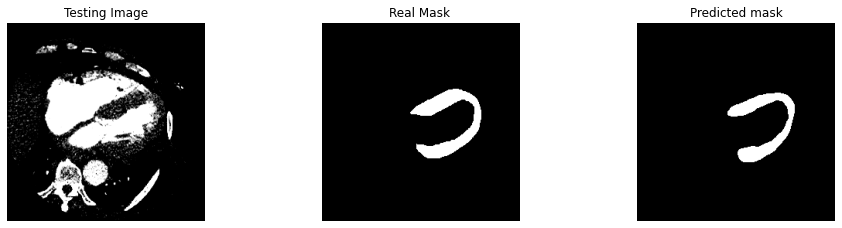

In [40]:
  test_img_number = random.randint(0, a.shape[0]-1)
  test_img = a[test_img_number]
  ground_truth=b[test_img_number]
  #test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)

  prediction = (model.predict(test_img_input)[0,0,:,:,0] > 0.5).astype(np.uint8)
  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.axis('off')
  plt.title('Testing Image')
  plt.imshow(test_img[0,:,:,0], cmap='gray')


  plt.subplot(232)
  plt.title('Real Mask ')
  plt.axis('off')
  plt.imshow(ground_truth[0,:,:,0], cmap='gray')
  plt.subplot(233)
  plt.axis('off')
  plt.title('Predicted mask')

  plt.imshow(prediction, cmap='gray')

  plt.show()

In [41]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[0,:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8353697


In [42]:
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,0,:,:,0]> 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[0,:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

1/1 [==============================] - 0s 25ms/step
0.47436523
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 29ms/step
0.487175
1/1 [==============================] - 0s 27ms/step
1.0
1/1 [==============================] - 0s 24ms/step
0.8778941
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 28ms/step
0.8186313
1/1 [==============================] - 0s 24ms/step
0.8353697
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 29ms/step
1.0
1/1 [==============================] - 0s 28ms/step
0.80114937
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 24ms/step
0.88605607
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 26ms/step
0.5155837
1/1 [==============================] - 0s 28ms/step
0.